In [11]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

In [12]:
df = pd.read_csv('https://raw.githubusercontent.com/doeungim/ADP_DE2/refs/heads/main/ADP_SONY/ADP_34/data/vlbw.csv')
df.head()

,lowph,pltct,race,bwt,gest,inout,twn,meth,toc,delivery,vent,pneumo,pda,cld,pvh,ivh,ipe,sex,dead
0,NaN,100.0,white,1250.0,35.0,born at Duke,0.0,0.0,0.0,abdominal,0.0,0.0,0.0,0.0,NaN,NaN,NaN,female,0
1,7.250000,244.0,white,1370.0,32.0,born at Duke,0.0,1.0,0.0,abdominal,0.0,0.0,0.0,0.0,NaN,NaN,NaN,female,0
2,7.059998,114.0,black,620.0,23.0,born at Duke,0.0,0.0,1.0,vaginal,1.0,0.0,0.0,NaN,NaN,NaN,NaN,female,1
3,7.250000,182.0,black,1480.0,32.0,born at Duke,0.0,1.0,0.0,vaginal,0.0,0.0,0.0,0.0,NaN,NaN,NaN,male,0
4,6.969997,54.0,black,925.0,28.0,born at Duke,0.0,0.0,0.0,abdominal,1.0,1.0,0.0,0.0,definite,definite,NaN,female,1


1.1 뇌출혈 관련 변수 3개 (pvh, ivh, ipe)의 변수들 간의 연관성을 확인하려한다. 변수를 두개씩 조합하여 교차표를 만들고 적절한 방법을 통해 연관성을 판단하라

In [13]:
from itertools import combinations 
from scipy import stats

lst = ['pvh','ivh','ipe']

res = []
for v1, v2 in list(combinations(lst, 2)) : 
    tab = pd.crosstab(df[v1], df[v2])
    stat, p_val , _ , _  = stats.chi2_contingency(tab)
    decision = '독립이다' if p_val > 0.05 else '독립이 아니다'
    res.append([v1,v2, p_val, decision])

print(pd.DataFrame(res))


     0    1             2        3
0  pvh  ivh  4.049839e-09  독립이 아니다
1  pvh  ipe  7.848100e-02     독립이다
2  ivh  ipe  4.632591e-12  독립이 아니다


2. Bleed -pvh,ivh,ipe가 모두 absent 값이라면 0, 셋 중 하나라도 positive or definite이면 1, 그 외 na

In [14]:
#np.where(
#    (df[['pvh','ivh','ipe']] == 'absent').all(axis = 1) , 0, 
#    np.where(
#        (df[['pvh','ivh','ipe']].isin(['positive','definite'])).any(axis = 1) , 1 , np.nan
#    )
#)

def bleed(x) : 
    if x['pvh'] == 'absent' and x['ivh'] == 'absent' and x['ipe'] == 'absent' : 
        return 0 
    elif x[['pvh','ivh','ipe']].isin(['positive','definite']).any() :
        return 1 
    else :
        return np.nan 

df['bleed'] = df.apply(bleed, axis = 1)

Ind -pvh,ivh,ipe를 제외한 모든 컬럼이 결측치가 없으면 0, bleed가 결측이면 1, 나머지는 2

In [15]:
def ind(x) : 
    if x.drop(['pvh','ivh','ipe']).isna().sum() == 0 :
        return 0
    elif pd.isna(x['bleed']) : 
        return 1 
    else : 
        return 2 

df['ind'] = df.apply(ind, axis = 1)

pd.crosstab(df['ind'],df['bleed'], dropna = False)

bleed,0.0,1.0,NaN
ind,,,
0,240,110,0
1,0,0,193
2,66,62,0


1-3 pvh,ivh,ipe 컬럼을 제외하고 나머지 컬럼들에 대한 전처리를 진행하라
- 결측치 처리 (Bleed 컬럼 제외)
- 범주형 변수 변환
- dead를 종속변수로 가정하고 모델링에 적합하지 않다 생각하는 변수 제거 등

In [16]:
pre_df = df.copy()
pre_df = pre_df.drop(columns = ['pvh','ivh','ipe'] , axis = 1) 

for col in pre_df.columns : 
    if col == 'bleed' : 
        pre_df[col] = pre_df[col] 
    elif  pre_df[col].dtypes == 'object' : 
        pre_df[col] = pre_df[col].fillna(pre_df[col].mode()[0]) 
    else : 
        pre_df[col] = pre_df[col].fillna(df[col].mean()) 

pre_df.head()

,lowph,pltct,race,bwt,gest,inout,twn,meth,toc,delivery,vent,pneumo,pda,cld,sex,dead,bleed,ind
0,7.201903,100.0,white,1250.0,35.0,born at Duke,0.0,0.0,0.0,abdominal,0.0,0.0,0.0,0.000000,female,0,NaN,1
1,7.250000,244.0,white,1370.0,32.0,born at Duke,0.0,1.0,0.0,abdominal,0.0,0.0,0.0,0.000000,female,0,NaN,1
2,7.059998,114.0,black,620.0,23.0,born at Duke,0.0,0.0,1.0,vaginal,1.0,0.0,0.0,0.269421,female,1,NaN,1
3,7.250000,182.0,black,1480.0,32.0,born at Duke,0.0,1.0,0.0,vaginal,0.0,0.0,0.0,0.000000,male,0,NaN,1
4,6.969997,54.0,black,925.0,28.0,born at Duke,0.0,0.0,0.0,abdominal,1.0,1.0,0.0,0.000000,female,1,1.0,0


In [17]:
# Label Encoder 
from sklearn.preprocessing import LabelEncoder

cate_df= pd.DataFrame()
for col in pre_df.select_dtypes(include = 'object').columns :
    la = LabelEncoder()
    cate_df[col] = la.fit_transform(pre_df[col])

merge_df = pd.concat([pre_df.drop(columns = ['race','inout', 'delivery','sex'], axis = 1) , cate_df] , axis = 1)
merge_df

,lowph,pltct,bwt,gest,twn,meth,toc,vent,pneumo,pda,cld,dead,bleed,ind,race,inout,delivery,sex
0,7.201903,100.000000,1250.0,35.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0,NaN,1,3,0,0,0
1,7.250000,244.000000,1370.0,32.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0,NaN,1,3,0,0,0
2,7.059998,114.000000,620.0,23.0,0.0,0.0,1.0,1.0,0.0,0.0,0.269421,1,NaN,1,0,0,1,0
3,7.250000,182.000000,1480.0,32.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0,NaN,1,0,0,1,1
4,6.969997,54.000000,925.0,28.0,0.0,0.0,0.0,1.0,1.0,0.0,0.000000,1,1.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,7.239998,278.000000,805.0,26.0,0.0,0.0,0.0,1.0,1.0,0.0,1.000000,0,1.0,0,3,1,1,1
667,7.199997,290.000000,1200.0,30.0,0.0,0.0,0.0,1.0,0.0,1.0,1.000000,0,0.0,0,3,0,1,1
668,7.201903,201.615641,1150.0,29.0,0.0,0.0,0.0,1.0,0.0,1.0,1.000000,0,0.0,2,3,0,0,0
669,7.149998,173.000000,860.0,29.0,1.0,0.0,0.0,1.0,0.0,1.0,0.269421,1,0.0,2,3,0,0,0


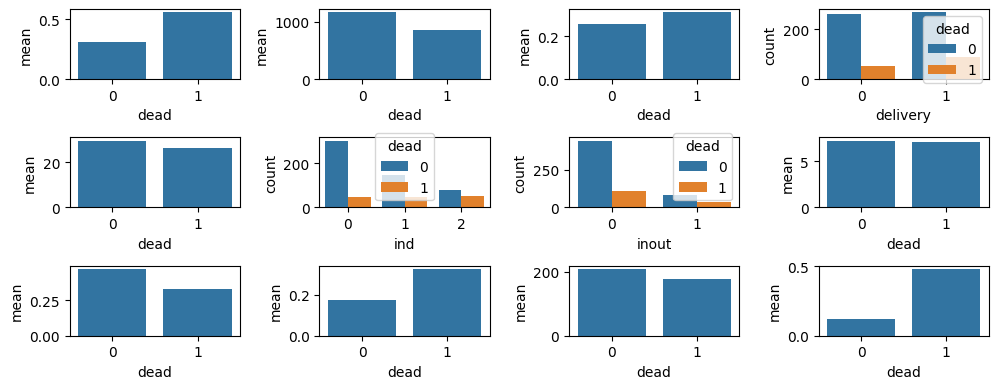

In [18]:
## EDA : dea별 합산 혹은 카운트 
import seaborn as sns
fig, axes = plt.subplots(3,4, figsize = (10, 4)) 

for axes, col in zip(axes.flatten(), merge_df.columns.difference(['dead'])) : 
    if col in ['toc','vent', 'ind','race','inout','delivery', 'sex'] : 
        sns.countplot(data = merge_df,
                      x = col,  
                      hue = 'dead', 
                      ax = axes)

    else : 
        target= merge_df.groupby('dead')[col].mean().reset_index(name = 'mean')
        sns.barplot(data = target, x = 'dead', y = 'mean' , ax = axes)


plt.tight_layout()
plt.show()

In [19]:
# 유의한 변수 선정하기 
res = []
for col in  merge_df.columns.difference(['dead']) : 
    if col in ['toc','vent', 'ind','race','inout','delivery', 'sex','bleed'] : 
        tab = pd.crosstab(merge_df['dead'] , merge_df[col].dropna())
        stat, p_val, _ , _ = stats.chi2_contingency(tab)
        decision = '유의하지않다' if p_val > 0.05 else '유의하다'
        res.append([col, p_val, decision]) 
          
    else : 
        t = merge_df.groupby('dead')[col].apply(list)
        stat, p_val = stats.ttest_ind(t[0], t[1])
        decision = '유의하지않다' if p_val > 0.05 else '유의하다'
        res.append([col, p_val, decision]) 
        
res = pd.DataFrame(res, columns = ['col','p_val','decision']) 
print(res)
check_cols = res.loc[res['decision'] == '유의하다','col'].tolist() 

model_df= merge_df[check_cols]

         col         p_val decision
0      bleed  1.050553e-05     유의하다
1        bwt  3.245787e-40     유의하다
2        cld  1.878454e-01   유의하지않다
3   delivery  1.516657e-02     유의하다
4       gest  7.113917e-44     유의하다
5        ind  5.940773e-09     유의하다
6      inout  9.991527e-03     유의하다
7      lowph  4.167358e-26     유의하다
8       meth  9.045205e-04     유의하다
9        pda  4.766406e-05     유의하다
10     pltct  2.724723e-05     유의하다
11    pneumo  3.355013e-24     유의하다
12      race  2.780301e-03     유의하다
13       sex  1.313357e-02     유의하다
14       toc  1.493262e-05     유의하다
15       twn  8.666771e-01   유의하지않다
16      vent  1.244918e-33     유의하다


1-5 Bleed를 예측하기 위한 단일 알고리즘 모델과 앙상블 모델을 비교 분석 서술하라.
- dead,pvh,ivh,ipe,Ind 컬럼은 제외
- 종속변수는 Bleed, Bleed가 결측치인 경우 해당 행 제외
- Ind값이 2인 데이터는 학습에 사용하고, Ind가 0인 데이터로 테스트를 진행하라
- 적절한 평가지표를 선택하라
- 변수중요도를 구해서 중요한 2개변수는 따로 출력을 한다.

In [60]:
from sklearn.preprocessing import StandardScaler
clean_df = pd.DataFrame() 

for col in model_df.columns : 
    if col in ['bwt','gest','lowph','pltct'] : 
        clean_df[col] = StandardScaler().fit_transform(model_df[[col]]).flatten() 
    else : 
        clean_df[col] = model_df[col]

clean_df.head(3)

,bleed,bwt,delivery,gest,ind,inout,lowph,meth,pda,pltct,pneumo,race,sex,toc,vent
0,NaN,0.589929,0,2.412530,1,0,0.000000,0.0,0.0,-1.334146,0.0,3,0,0.0,0.0
1,NaN,1.043390,0,1.230919,1,0,0.352818,1.0,0.0,0.556478,0.0,3,0,0.0,0.0
2,NaN,-1.790743,1,-2.313915,1,0,-1.040948,0.0,0.0,-1.150335,0.0,0,0,1.0,1.0


In [61]:

train_set = clean_df[clean_df['ind'] == 2].reset_index(drop = True)
train_set = train_set.drop(columns = ['ind'])

test_set = clean_df[clean_df['ind'] == 0].reset_index(drop = True)
test_set = test_set.drop(columns = ['ind']) 

x_train = train_set.drop(columns = ['bleed'])
y_train = train_set['bleed']

x_test = test_set.drop(columns = ['bleed'])
y_test = test_set['bleed']

In [62]:
# 단일 알고리즘 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# 평가지표 
from sklearn.metrics import accuracy_score, f1_score

def eval (name, model) : 
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    accu = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred) 

    return name, accu, f1 

res = []
model_lst = []
for name, model in [['Decision_Tree', DecisionTreeClassifier()] , ['RandomForest' ,RandomForestClassifier()]]  : 
    name, accu, f1 = eval(name, model) 
    res.append([name, accu, f1])
    model_lst.append([name, model])

pd.DataFrame(res, columns = ['Model_Name' , 'Accuracy_Score','F1_score'])


,Model_Name,Accuracy_Score,F1_score
0,Decision_Tree,0.571429,0.342105
1,RandomForest,0.577143,0.327273


In [63]:
# 변수중요도를 구해서 중요한 2개변수는 따로 출력

for name, model in model_lst : 
    if name == 'Decision_Tree' : 
        imp = model.feature_importances_
        feature = model.feature_names_in_
        dt_df_imp = pd.Series(imp, index = feature).sort_values(ascending= False).head(2)

    elif name == 'RandomForest' : 
        imp = model.feature_importances_
        feature = model.feature_names_in_
        rf_df_imp = pd.Series(imp, index = feature).sort_values(ascending= False).head(2)
        
print("Decision Tree 중요 변수 Top2")
print(dt_df_imp)
print('')
print("\nRandomForest 중요 변수 Top2")
print(rf_df_imp)

Decision Tree 중요 변수 Top2
bwt     0.258100
gest    0.180576
dtype: float64


RandomForest 중요 변수 Top2
lowph    0.188749
bwt      0.174553
dtype: float64


#### 1-6 dead 컬럼을 예측하기 위한 기계학습 모델
- pvh,ivh,ipe,Ind 제외 / Bleed 포함
- Ind 값이 1,2인 경우 학습데이터 / 0인 경우 테스트데이터
- 모델링 및 평가 방식은 1-5와 동일하게 진행

In [77]:
mdf2 = clean_df

train_set = mdf2[mdf2['ind'].isin([1,2])]
train_set = train_set[train_set['bleed'].notnull()].reset_index(drop =True)

x_train = train_set.drop(columns = ['bleed'], axis = 1)
y_train = train_set['bleed']


test_set = mdf2[mdf2['ind'] == 0]
test_set = test_set[test_set['bleed'].notnull()].reset_index(drop =True)

x_test = test_set.drop(columns = ['bleed'], axis = 1)
y_test = test_set['bleed'] 


def eval (name, model) : 
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    accu = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred) 

    return name, accu, f1 

res = []
model_lst = []
for name, model in [['Decision_Tree', DecisionTreeClassifier()] , ['RandomForest' ,RandomForestClassifier()]]  : 
    name, accu, f1 = eval(name, model) 
    res.append([name, accu, f1])
    model_lst.append([name, model])

pd.DataFrame(res, columns = ['Model_Name' , 'Accuracy_Score','F1_score'])


# 변수중요도를 구해서 중요한 2개변수는 따로 출력

for name, model in model_lst : 
    if name == 'Decision_Tree' : 
        imp = model.feature_importances_
        feature = model.feature_names_in_
        dt_df_imp = pd.Series(imp, index = feature).sort_values(ascending= False).head(2)

    elif name == 'RandomForest' : 
        imp = model.feature_importances_
        feature = model.feature_names_in_
        rf_df_imp = pd.Series(imp, index = feature).sort_values(ascending= False).head(2)
        
print("Decision Tree 중요 변수 Top2")
print(dt_df_imp)
print('')
print("\nRandomForest 중요 변수 Top2")
print(rf_df_imp)

Decision Tree 중요 변수 Top2
bwt      0.299006
lowph    0.202384
dtype: float64


RandomForest 중요 변수 Top2
lowph    0.187980
bwt      0.180058
dtype: float64


In [2]:

df = pd.read_csv('https://raw.githubusercontent.com/doeungim/ADP_DE2/refs/heads/main/ADP_SONY/ADP_34/data/m2_source.csv')
df.head(4)

,일자,자원,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,hour_24
0,2021-01-01,태양광,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.07,...,22.62,15.22,8.02,1.89,0.10,0.81,0.11,0.01,0.01,0.01
1,2021-01-01,풍력,119.64,105.18,106.19,76.71,65.16,79.13,47.67,39.37,...,29.19,27.11,23.78,19.02,36.62,24.00,19.66,14.78,23.45,21.14
2,2021-01-02,태양광,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.13,...,109.39,76.44,30.46,6.49,4.43,3.87,1.45,0.84,0.13,0.01
3,2021-01-02,풍력,36.33,54.85,68.76,59.23,61.03,85.77,75.80,64.57,...,83.97,125.86,154.00,157.83,176.06,172.67,143.09,144.29,128.74,135.89


1. 전력량 데이터에서 결측치를 제거하라.
2. 결측치가 존재하는 시간대의 동일 일자, 동일 자원 데이터의 직전 값과 다음 값의 평균으로 대치한다.
3. 연속된 시간대의 결측치가 있다면 결측치가 아닌 이전 시간대의 값과 이후 시간대의 값의 평균으로 모든 연속 시간대 결 측치를 대치한다.
4. 맨앞이나 맨뒤에 결측치가 존재한다면 직전, 직후 시간대 값으로 대치한다.

In [3]:
power = df.copy()

power['hour_1'] = power['hour_1'].fillna(power['hour_2'])
power['hour_24'] = power['hour_24'].fillna(power['hour_23']) 

# 결측치가 존재하는 시간대의 동일 일자, 동일 자원 데이터의 직전 값과 다음 값의 평균으로 대치 
mean = (power.iloc[:,2:].ffill(axis= 1) + power.iloc[:,2:].bfill(axis = 1)) / 2 
power.iloc[:,2:] = mean


In [4]:
#총 전력량
# 2. 결측치를 제거한 전력량 데이터에 대해 총전력량(태양광 + 풍력 발전량의 합)을 구한다.
#     - 동일 일자 동일 시간대에 대해 태양광과 풍력의 합을 구한다. 하나의 일자는 하나의 행에 시간대별 총전력량을 표현해야한다.
#     - 특정일자에 태양광 또는 풍력이 하나만 있는 경우에는 해당 자원의 전력량을 2배로 한다.

power_sum = power.groupby(['일자','자원']).sum().reset_index()
power_sum.head()

,일자,자원,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,hour_24
0,2021-01-01,태양광,0.00,0.00,0.000,0.00,0.01,0.00,0.00,0.07,...,22.62,15.22,8.02,1.89,0.10,0.81,0.11,0.01,0.01,0.01
1,2021-01-01,풍력,119.64,105.18,106.190,76.71,65.16,79.13,47.67,39.37,...,29.19,27.11,23.78,19.02,36.62,24.00,19.66,14.78,23.45,21.14
2,2021-01-02,태양광,0.00,0.00,0.000,0.00,0.00,0.00,0.00,0.13,...,109.39,76.44,30.46,6.49,4.43,3.87,1.45,0.84,0.13,0.01
3,2021-01-02,풍력,36.33,54.85,68.760,59.23,61.03,85.77,75.80,64.57,...,83.97,125.86,154.00,157.83,176.06,172.67,143.09,144.29,128.74,135.89
4,2021-01-03,태양광,0.04,0.01,0.005,0.00,0.03,0.02,0.00,0.40,...,90.94,43.06,18.88,7.51,5.32,6.05,3.24,1.94,0.64,0.23


In [5]:
power_pivot = power_sum.melt(id_vars = ['일자','자원'] , 
              var_name = 'hour',
              value_name = '총전력량')
power_pivot.head()

,일자,자원,hour,총전력량
0,2021-01-01,태양광,hour_1,0.00
1,2021-01-01,풍력,hour_1,119.64
2,2021-01-02,태양광,hour_1,0.00
3,2021-01-02,풍력,hour_1,36.33
4,2021-01-03,태양광,hour_1,0.04


In [6]:
# 특정일자에 태양광 또는 풍력이 하나만 있는 경우에는 해당 자원의 전력량을 2배로 
# Groupby 로 nunique()가 1인 날짜 인덱스만 추출 
indx = power_pivot.groupby('일자')['자원'].nunique() == 1
one_day = indx[indx].index

# 자원이 하나면 2배 처리 
power_pivot.loc[power_pivot['일자'].isin(one_day) ,'총전력량'] *= 2 

In [7]:
power_group = power_pivot.groupby(['일자','hour'])['총전력량'].sum().reset_index()
power_group['hour'] = power_group['hour'].astype(str).str.split('_').str[1].str.zfill(2)
power_group['date'] = pd.to_datetime(power_group['일자'] + ' ' + (power_group['hour'].astype(int) - 1).astype(str) ,  format = '%Y-%m-%d %H' )
power_group = power_group.sort_values('date')

# season 생성
# 1,2월 제거 
filter_power = power_group[~power_group['date'].dt.month.isin([1,2])]

filter_power['season'] =  filter_power['date'].dt.month.apply(lambda x : 0 if x in [3,4,5] else 
                                                                         1 if x in [6,7,8] else 
                                                                         2) 

final_power = filter_power[['date','총전력량','season']]
final_power.head(5)

C:\Users\i2max-DoeunKim\AppData\Local\Temp\ipykernel_35816\1115110696.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_power['season'] =  filter_power['date'].dt.month.apply(lambda x : 0 if x in [3,4,5] else


,date,총전력량,season
1416,2021-03-01 00:00:00,99.59,0
1427,2021-03-01 01:00:00,112.45,0
1433,2021-03-01 02:00:00,123.76,0
1434,2021-03-01 03:00:00,126.22,0
1435,2021-03-01 04:00:00,136.05,0


In [8]:
w = pd.read_csv('https://raw.githubusercontent.com/doeungim/ADP_DE2/refs/heads/main/ADP_SONY/ADP_34/data/m2_weather.csv')
w.head(3)

,일시,기온,강수량,풍속,습도,일조,일사,적설,전운량,지면온도
0,2021_01_01@0,4.5,NaN,6.1,53.0,NaN,NaN,NaN,9.0,2.2
1,2021_01_01@1,4.3,NaN,5.6,58.0,NaN,NaN,NaN,9.0,2.4
2,2021_01_01@2,4.2,NaN,5.5,54.0,NaN,NaN,NaN,10.0,2.3


In [9]:
w['일시'] = pd.to_datetime(w['일시'].str.replace('_','-').str.replace('@',' ') ,format = '%Y-%m-%d %H' ) 

In [10]:
# 기상데이터 결측치 처리
# 5. 기상데이터의 결측치를 처리한다
#     - 강수량, 일조, 일사, 적설은 0으로 채운다.
#     - 풍속, 습도는 직전값으로 전운량과 지면온도는 전체 평균값으로 대치한다. + 기온도 직전값 

fw = w.copy()
for col in fw.columns : 
    if col in ['강수량','일조','일사','적설'] :
        fw[col] = fw[col].fillna(0) 
    elif col in ['풍속','습도','기온'] : 
        fw[col] = fw[col].ffill() 
    elif col in ['전운량','지면온도'] : 
        fw[col] = fw[col].fillna(fw[col].mean()) 

In [11]:
m_df = pd.merge(final_power, fw, how = 'left' , left_on = 'date', right_on = '일시').drop(columns = 'date')
m_df.head()

,총전력량,season,일시,기온,강수량,풍속,습도,일조,일사,적설,전운량,지면온도
0,99.59,0,2021-03-01 00:00:00,16.6,0.0,4.6,73.0,0.0,0.0,0.0,6.0,12.3
1,112.45,0,2021-03-01 01:00:00,17.6,0.0,5.1,68.0,0.0,0.0,0.0,10.0,12.8
2,123.76,0,2021-03-01 02:00:00,17.6,0.0,4.7,67.0,0.0,0.0,0.0,9.0,12.6
3,126.22,0,2021-03-01 03:00:00,17.9,0.0,4.6,66.0,0.0,0.0,0.0,9.0,12.5
4,136.05,0,2021-03-01 04:00:00,18.8,0.0,6.2,63.0,0.0,0.0,0.0,9.0,12.5


##### 2.2 전처리 완료된 데이터의 기술 통계량 및 EDA를 실시하라 (시각화 포함)

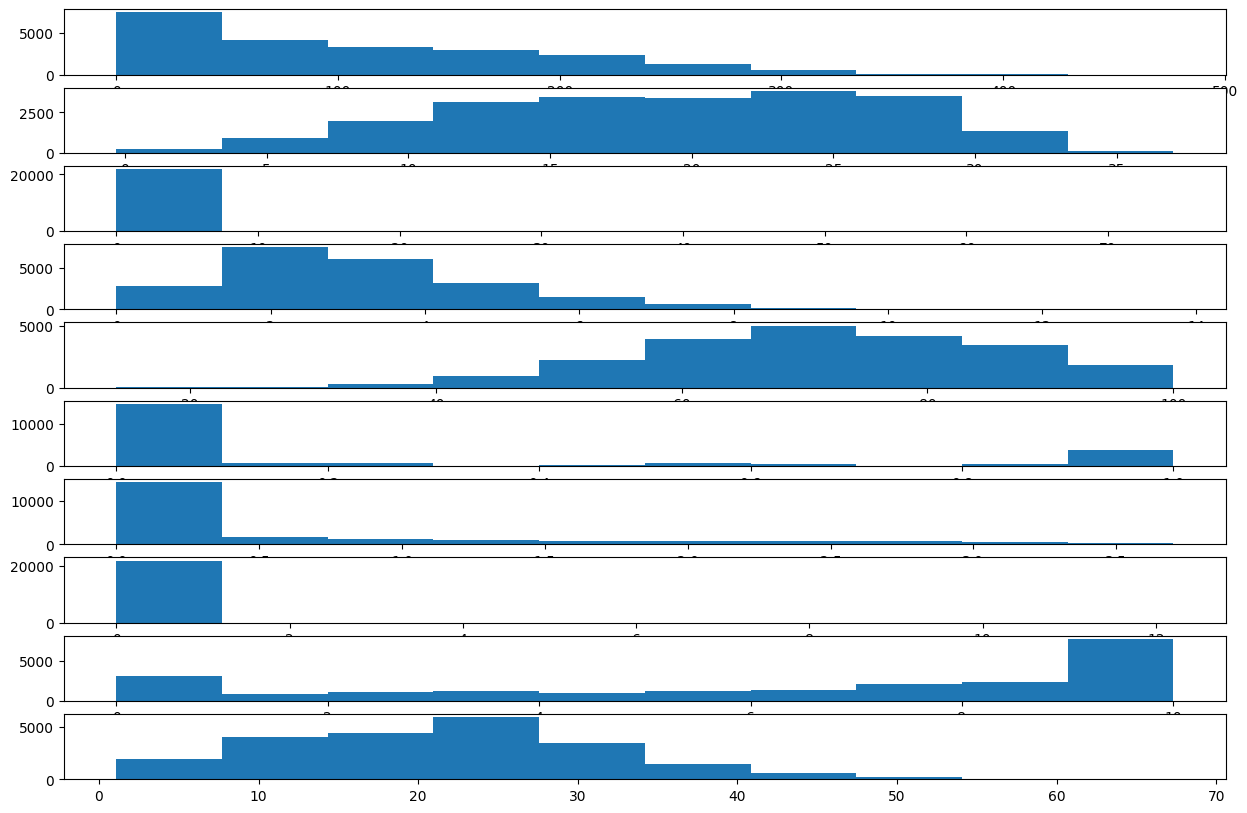

<Figure size 640x480 with 0 Axes>

In [12]:
cols = ['총전력량',  '기온', '강수량', '풍속','습도', '일조', '일사', '적설',  '전운량', '지면온도']

fig, axes = plt.subplots(10, 1, figsize = (15, 10))
for axes , c in zip(axes.flatten(), m_df[cols].columns) : 
    axes.hist(m_df[c])

plt.show()
plt.tight_layout()


2-3
- 총전력량을 종속변수로 하고 종속변수와 다른 연속형 변수들간의 상관관계 분석을 진행하라. 유의확률을 포함하여 분석결과를 서술하라.
- season에 따라 종속변수간의 차이가 있는지 통계적으로 확인하고 분석결과를 서술하라

In [13]:
# 총전력과, 다른 연속형 변수 상관관계 
from scipy.stats import pearsonr , f_oneway
X = m_df.drop(columns = ['총전력량','season','일시'], axis = 1)
y = m_df['총전력량']

In [14]:
res = []
for x in X.columns : 
    cor, p_val = pearsonr(m_df[x] , y) 
    decision = '유의하다' if p_val < 0.05 else '유의하지 않다'
    res.append([x , cor, p_val, decision])

pd.DataFrame(res)

,0,1,2,3
0,기온,0.012500,6.353797e-02,유의하지 않다
1,강수량,-0.005195,4.406898e-01,유의하지 않다
2,풍속,0.515133,0.000000e+00,유의하다
3,습도,-0.338387,0.000000e+00,유의하다
4,일조,0.508636,0.000000e+00,유의하다
5,일사,0.629051,0.000000e+00,유의하다
6,적설,0.008620,2.007346e-01,유의하지 않다
7,전운량,-0.028286,2.679824e-05,유의하다
8,지면온도,0.236017,1.488140e-276,유의하다


4.50618661623794e-51
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
     0      1 -20.2194    0.0 -23.6481 -16.7907   True
     0      2     -2.6 0.1393   -5.811    0.611  False
     1      2  17.6194    0.0  14.4084  20.8304   True
------------------------------------------------------


<Figure size 800x600 with 0 Axes>

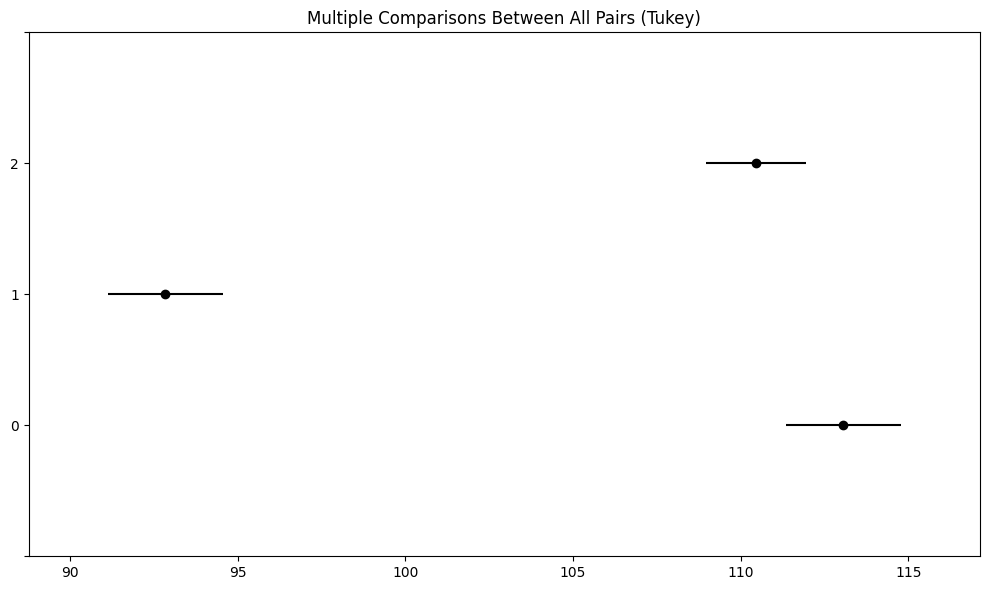

In [15]:
# season에 따라 종속변수간의 차이가 있는지 통계적으로 확인하고 분석결 
# 귀무가설 : 전력량은 같다
# 대립가설 : 전력량은 다르디 

group = [ group for name, group in m_df.groupby('season')['총전력량'] ]

stats, p_val = f_oneway(*group)
print(p_val) 

from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog = m_df['총전력량'] , groups = m_df['season'])
print(tukey)
plt.figure(figsize=(8,6))
tukey.plot_simultaneous()
plt.tight_layout()
plt.show()

2-4 아래 기준으로 회귀모델링을 진행하고 평가하라.

- 21년,22년도를 학습데이터, 23년도를 평가데이터로 사용한다.
- RMSE를 포함한 적절한 평가지표 2가지로 판단
- 일반 회귀모형 1개, 기계학습 모델 1개로 진행한다.

3-1. 성별,교육방법에 따른 성적의 차이가 존재하는지 확인하려한다. 가설 검정 전 필요한 사전 가정을 설명하고 확인하라.

In [16]:
df = pd.read_csv('https://raw.githubusercontent.com/doeungim/ADP_DE2/refs/heads/main/ADP_SONY/ADP_34/data/student_scores.csv')
df.head()

# 각 하나의 id에 3가지의 성적 점수가 존재 
# 동일 학생에게 3개의 교육방법을 적용 >> 반복 측정 

,id,성별,traindition,online,mix
0,1,Male,69,74,68
1,2,Male,59,65,63
2,3,Male,60,75,63
3,4,Male,79,52,76
4,5,Male,100,77,67


In [17]:
# Mixed ANOVA 는 DV가 여러개로는 실행 할 수 없고 반드시 Melt 형태해야한다. 
df_melt =  df.melt(id_vars = ['id','성별'] , 
           value_vars = ['traindition','online','mix'] ,
           var_name = '교육방법', 
           value_name = '점수') 

# 정규성 - melt된 내용 뺴고 
from scipy.stats import shapiro, levene
res = []

for col in ['traindition', 'online','mix'] :
    for key, group in df.groupby('성별') : 
        stats, p_val = shapiro(group[col])
        decision = '정규분포이다' if p_val > 0.05 else '정규분포가 아니다'
        res.append([key, col, p_val, decision])

print(pd.DataFrame(res , columns = ['성별','교육방식','p_value','decision']))


# 등분산성 
for col in ['traindition','online','mix'] : 
    g = [group[col] for name, group in df.groupby('성별')]
    stat, lev = levene(*g)
    decision = '등분산이다' if lev > 0.05 else '등분산이 아니다'
    print([col, lev , decision])

# 3) 구형성 
# Within-Factor (3수준)에 대해서 필요 

# 4) Mixed ANOVA 실행 
import pingouin as pg 

mix = pg.mixed_anova(
    dv = '점수' , 
    within = '교육방법', 
    between = '성별' , 
    subject = 'id' , 
    data = df_melt
)

display(mix)

print('''
1. 성별 : p_value 0.65로 유의하지않다. 성별에 따른 성취도 차이는 없다
2. 교육방법 : p_Value 0.61, 교육방법에 따른 성취도 차이가 없다.(특정 교육 방법이 더 우수한건 아니다)
3. 성별 X 교육방법 : 상호작용이 없다. 
''')

       성별         교육방식   p_value   decision
0  Female  traindition  0.472527     정규분포이다
1    Male  traindition  0.097687     정규분포이다
2  Female       online  0.048999  정규분포가 아니다
3    Male       online  0.683060     정규분포이다
4  Female          mix  0.994322     정규분포이다
5    Male          mix  0.083163     정규분포이다
['traindition', np.float64(0.2084760700429232), '등분산이다']
['online', np.float64(0.7298450808705663), '등분산이다']
['mix', np.float64(0.7952349158120535), '등분산이다']


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,성별,22.533333,1,38,22.533333,0.199343,0.657785,0.005219,NaN
1,교육방법,117.650000,2,76,58.825000,0.482945,0.618844,0.012550,0.976104
2,Interaction,50.516667,2,76,25.258333,0.207367,0.813179,0.005427,NaN



1. 성별 : p_value 0.65로 유의하지않다. 성별에 따른 성취도 차이는 없다
2. 교육방법 : p_Value 0.61, 교육방법에 따른 성취도 차이가 없다.(특정 교육 방법이 더 우수한건 아니다)
3. 성별 X 교육방법 : 상호작용이 없다. 



3.2 통계검정을 진행 후 검정 후 주효과, 상호작용 검정을 진행하라 </br>
3.3 주 효과에 대한 사후검정을 진행하라

In [18]:
# 주효과 
# 1) 성별효과 -> 2수준으로 사후검정 불필요 
# 2) 교육 방법 : 사후검정의 목적은 여러 수준간의 pairwise 비교인데, 두개라서 필요가 없다. 
# 3) 상호작용 : 성별 x 교육방법 

# 2) 교육방법에 대한 사후검정 (주효과 사후검정)
posthoc  = pg.pairwise_tests(
                                dv = '점수', 
                                within  = '교육방법', 
                                subject = 'id', 
                                data = df_melt, 
                                parametric = True, 
                                padjust = 'bonf'
                            ) 
posthoc

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,교육방법,mix,online,True,True,-0.514835,39.0,two-sided,0.609574,1.000000,bonf,0.193,-0.107786
1,교육방법,mix,traindition,True,True,0.478733,39.0,two-sided,0.634802,1.000000,bonf,0.19,0.112853
2,교육방법,online,traindition,True,True,1.000655,39.0,two-sided,0.323162,0.969487,bonf,0.272,0.226435


In [19]:
# 상호작용 유의시 simple main effect 
interaction = pg.pairwise_tests(
                                dv = '점수', 
                                between = '성별', 
                                within  = '교육방법', 
                                subject = 'id', 
                                data = df_melt, 
                                padjust = 'bonf'
)
interaction

,Contrast,교육방법,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,교육방법,-,mix,online,True,True,-0.514835,39.0,two-sided,0.609574,1.000000,bonf,0.193,-0.107786
1,교육방법,-,mix,traindition,True,True,0.478733,39.0,two-sided,0.634802,1.000000,bonf,0.19,0.112853
2,교육방법,-,online,traindition,True,True,1.000655,39.0,two-sided,0.323162,0.969487,bonf,0.272,0.226435
3,성별,-,Female,Male,False,True,0.446479,38.0,two-sided,0.657785,NaN,NaN,0.334,0.138384
4,교육방법 * 성별,mix,Female,Male,False,True,0.434880,38.0,two-sided,0.666110,1.000000,bonf,0.333,0.134789
5,교육방법 * 성별,online,Female,Male,False,True,0.601592,38.0,two-sided,0.551018,1.000000,bonf,0.357,0.186461
6,교육방법 * 성별,traindition,Female,Male,False,True,-0.275289,38.0,two-sided,0.784585,1.000000,bonf,0.318,-0.085325


#### 4. 통계 2

In [20]:
df = pd.read_csv('https://raw.githubusercontent.com/doeungim/ADP_DE2/refs/heads/main/ADP_SONY/ADP_34/data/s4.csv')
df.head()

,ID,studytime,failures,schoolsup,famsup,absences,score
0,ID_1,2,0,yes,no,4,11
1,ID_2,2,0,no,yes,2,11
2,ID_3,2,0,yes,no,6,13
3,ID_4,3,0,no,yes,0,14
4,ID_5,2,0,no,yes,0,13


4-1 회귀모델이 유의한지 F검정에 대한 분석 및 결정계수 제시 및 해석

In [21]:
X = df.drop(columns = ['ID','score'], axis = 1)
y = df['score']

X['schoolsup'] = X['schoolsup'].map({'yes': 1, 'no' : 0})
X['famsup'] = X['famsup'].map({'yes': 1, 'no' : 0}) 

import statsmodels.api as sm 
add_x = sm.add_constant(X)
model = sm.OLS(y, add_x).fit() 
print(model.summary()) 

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     30.77
Date:                Thu, 18 Dec 2025   Prob (F-statistic):           4.23e-28
Time:                        10:52:01   Log-Likelihood:                -1544.8
No. Observations:                 649   AIC:                             3102.
Df Residuals:                     643   BIC:                             3129.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.8563      0.305     35.649      0.0

4-2 잔차를 통해 회귀모델의 유의성 검정

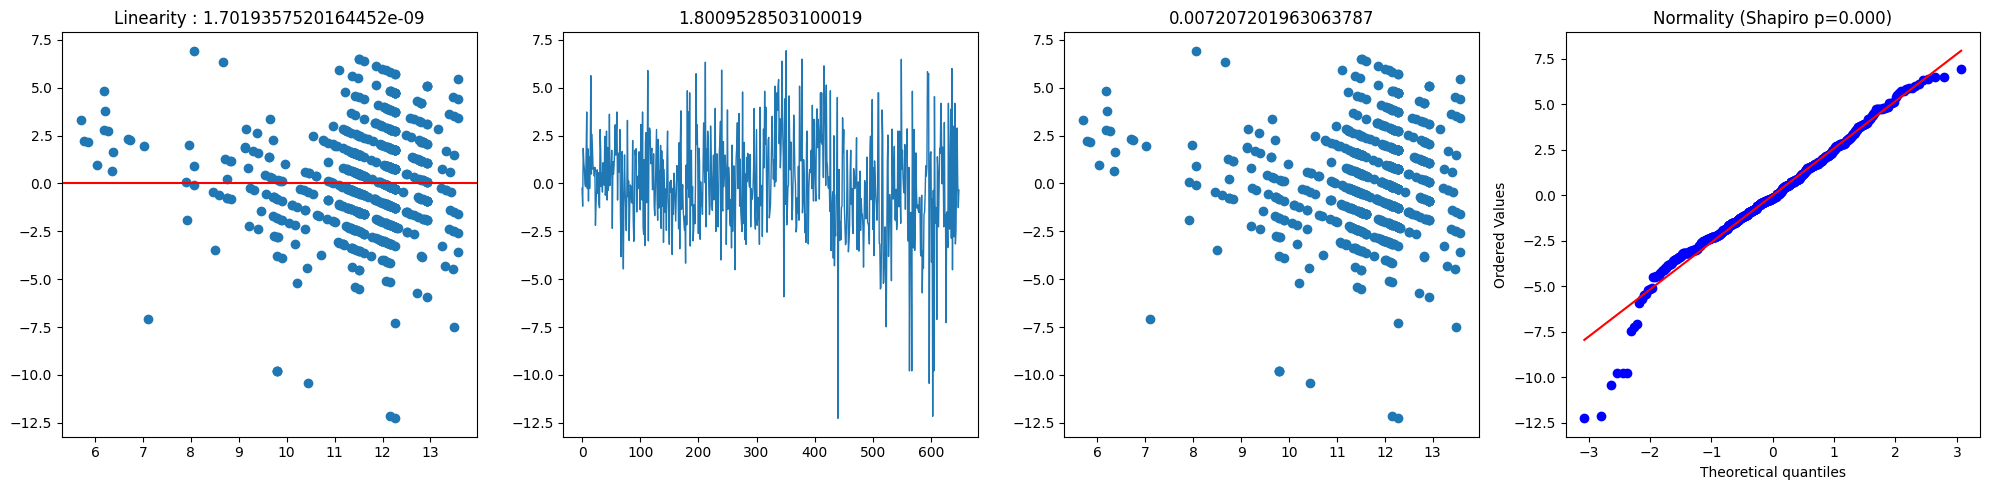

In [22]:
from scipy.stats import shapiro, probplot 
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import shapiro, probplot

resid = model.resid
pred = model.fittedvalues 

fig, axes = plt.subplots(1,4, figsize = (20, 5))

# 1. 선형성 
axes[0].scatter(pred, resid)
axes[0].axhline(0, color = 'r')
stat, p_val = shapiro(resid) 
axes[0].set_title(f'Linearity : {p_val}') 


# 2.독립성 
dw= durbin_watson(resid) 
axes[1].plot(resid.values, linewidth = 1)
axes[1].set_title(f'{dw}')

# 3.등분산성 
bp = het_breuschpagan(resid, model.model.exog)
bp_p = bp[1]
axes[2].scatter(pred, resid)
axes[2].set_title(f'{bp_p}')
# 4. 정규성
shap_p = shapiro(resid).pvalue
probplot(resid, dist='norm', plot=axes[3])
axes[3].set_title(f'Normality (Shapiro p={shap_p:.3f})')

plt.tight_layout()
plt.show()

4-3 다중공선성 VIF

In [26]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 

vif = pd.DataFrame()
vif['col'] = X.columns
vif['vif'] = [variance_inflation_factor(X.values , i) for i in range(X.shape[1])]

print(vif)

         col       vif
0  studytime  2.584695
1   failures  1.129932
2  schoolsup  1.132317
3     famsup  2.437308
4   absences  1.501333
